# Auto Accidents Dashboard

## Import dask_cuda, dask

In [ ]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

client = Client(LocalCUDACluster())

### Display total available GPU resources

In [2]:
gpu_info = client.cluster.scheduler_info['workers'].values()

print(f"Total GPUs: {len(gpu_info)}\n")
for gpu in gpu_info:
    mem = f"{gpu['memory_limit']/(1024 **3):.2f} GB"
    gpu_mem = f"{gpu['gpu']['memory-total']/(1024 **3):.2f} GB"
    gpu_name = gpu['gpu']['name']
    print(f"{gpu_name}:\n\tMemory assigned: {mem}, Total Memory: {gpu_mem}")

Total GPUs: 2

NVIDIA TITAN RTX:
	Memory assigned: 15.63 GB, Total Memory: 24.00 GB
Quadro GV100:
	Memory assigned: 15.63 GB, Total Memory: 32.00 GB


## Import cuxfilter

In [ ]:
import cuxfilter
import dask_cudf
from cuxfilter.layouts import feature_and_base

In [ ]:
#update data_dir if you have downloaded datasets elsewhere
DATA_DIR = '../data'

## Download required datasets

In [ ]:
! curl https://s3.us-east-2.amazonaws.com/rapidsai-data/viz-data/auto_accidents.arrow.gz --create-dirs -o $DATA_DIR/auto_accidents.arrow.gz

In [ ]:
from cuxfilter.sampledata import datasets_check
datasets_check('auto_accidents', base_dir=DATA_DIR)

## Load required datasets using dask_cudf

Using `dask_cudf.DataFrame.persist()` before passing it to cuxfilter.DataFrame turns a lazy Dask collection into a Dask collection with the same metadata, but now with the results fully computed or actively computing in the background. 

Passing a `dask_cudf.DataFrame` without `persist()` is also supported.

In [6]:
from cuxfilter.dataframe import read_arrow
import cudf

cudf_df = cudf.DataFrame.from_arrow(read_arrow(DATA_DIR + '/auto_accidents.arrow'))
cudf_ddf = dask_cudf.from_cudf(cudf_df, npartitions=2).persist()

cudf_ddf['ST_CASE'] = cudf_ddf['ST_CASE'].astype('float64')

In [7]:
cudf_ddf

,STATE,ST_CASE,VEH_NO,PER_NO,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,HARM_EV,REL_ROAD,FATALS,VIN,MOD_YEAR,DEFORMED,FIRE_EXP,PREV_ACC,DR_DRINK,SEX,INJ_SEV,DRINKING,LAG_MINS,MAKE,MODEL,OVERALL_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,OVERALL_FRNT_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,SIDE_BARRIER_STAR,COMB_FRNT_STAR,COMB_REAR_STAR,OVERALL_SIDE_STARS,SIDE_POLE_STARS,ROLLOVER_STARS,WEATHER_VAL_0,WEATHER_VAL_1,WEATHER_VAL_2,WEATHER_VAL_3,WEATHER_VAL_4,WEATHER_VAL_5,WEATHER_VAL_6,WEATHER_VAL_7,WEATHER_VAL_8,WEATHER_VAL_9,DECEASED,MAN_COLL,SEAT_POS,PER_TYP,ROUTE,RELJCT2,AGE,LAG_HRS,ALC_RES,UNITS_SOLD,LATITUDE,LONGITUD,dropoff_x,dropoff_y
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64
674153,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891291,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Define Charts

In [ ]:
cux_df = cuxfilter.DataFrame.from_dataframe(cudf_ddf)

In [ ]:
# add mappings for day of week
label_map = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday',
    9: 'Unknown'
}

gtc_demo_red_blue_palette = [ "#3182bd", "#6baed6", "#7b8ed8", "#e26798", "#ff0068" , "#323232" ]

In [ ]:
chart1 = cuxfilter.charts.scatter(x='dropoff_x', y='dropoff_y', aggregate_col='DAY_WEEK', aggregate_fn='mean',
                                        tile_provider="CartoLight",
                                         color_palette=gtc_demo_red_blue_palette,pixel_shade_type='linear', unselected_alpha=0.2)

chart2 = cuxfilter.charts.bar('YEAR')

chart3 = cuxfilter.charts.multi_select('DAY_WEEK', label_map=label_map)

## Create a dashboard object

In [ ]:
d = cux_df.dashboard([chart1, chart2], sidebar=[chart3], layout=cuxfilter.layouts.feature_and_base,theme = cuxfilter.themes.rapids, title='Auto Accident Dataset')

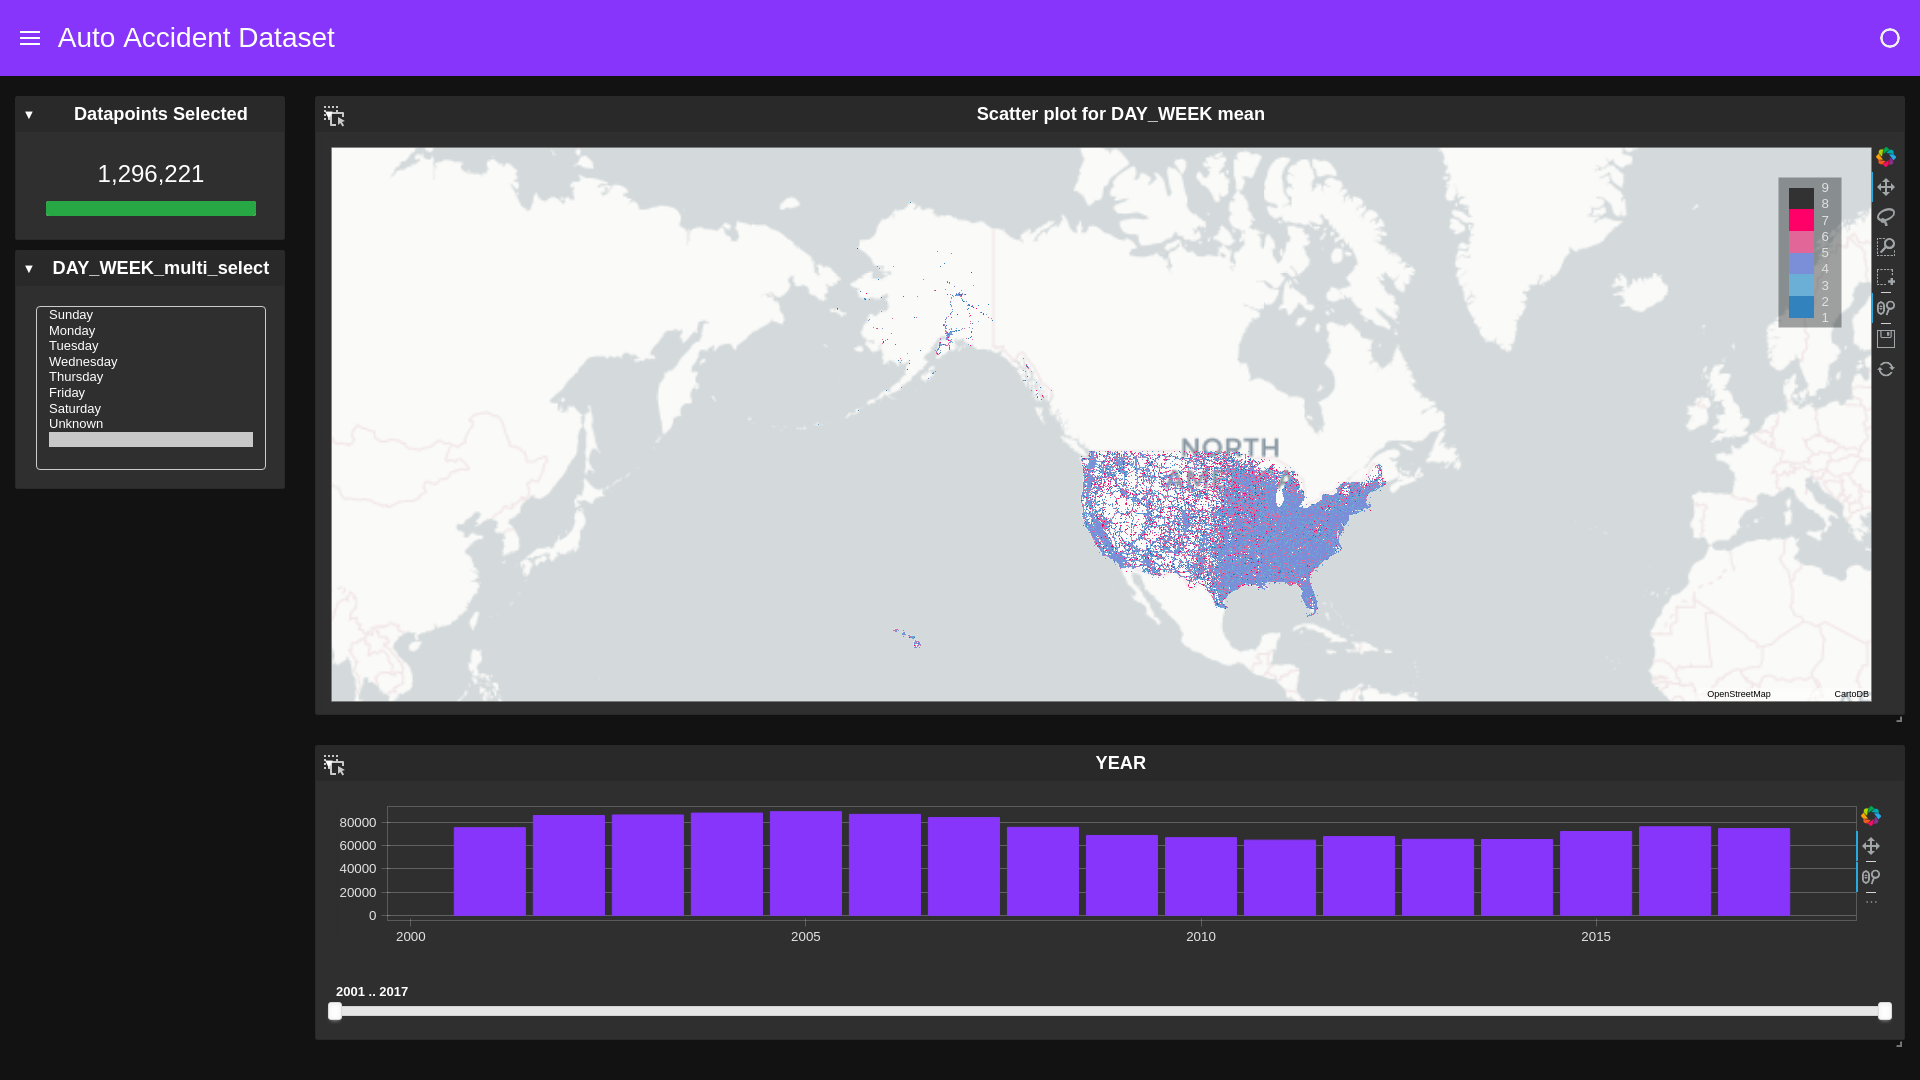

In [16]:
#execute below line for dashboard preview
await d.preview()

## Starting the dashboard

1. d.show('current_notebook_url:current_notebook_port') remote dashboard

2. d.app() inline within the notebook cell

Incase you need to stop the server:

- d.stop()

In [ ]:
# d.show() # notebook_url="http://localhost:8888"
# d.app() # run the dashboard within the notebook cell

## Export the queried data into a dataframe

In [ ]:
queried_df = d.export()